In [8]:
from specutils.analysis import equivalent_width
from specutils.fitting import fit_generic_continuum
from specutils import Spectrum1D
from specutils import SpectralRegion
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

#Define source path where the files are
source=Path("/home/nicolas/Documents/Research/PhD/JWST-Data/PRISM/Spectra1D/")
mast_folder=source / "MAST"
jades_folder=source / "JADES"

df = pd.read_csv("short-table.tsv", sep='\t')

ID_array = df["NIRSpec_ID"]
JADES_files = df["JADES_FILENAME"]
MAST_files = df["MAST_FILENAME"]
z_array = df["redshift"]




Compute Equivalent Width (EW) of Halpha for some examples

In [ ]:
# Define function to plot spectrum 

def plot__mast_spectrum(MAST_file, z):
  
  
    # ~ fits.open('file.fits')
    t_MAST=Table.read(MAST_file, hdu="EXTRACT1D")
    w_MAST=t_MAST['WAVELENGTH']
    flux_MAST=t_MAST['FLUX'] #flux in Jy
    
    #rest_w=w/(1+z) #in micras
    #rest_w_Angstrom=rest_w*1e-6/1e-10 # rest wavelength in Angstrom
    w_Angstrom=w_MAST*1e-6/1e-10 # observed wavelength in Angstrom
    flux_ergs = 2.99792458E-05 *flux_MAST / w_Angstrom**2. #flux in erg s^-1 cm^-2 A^-1


    plt.rcParams["figure.figsize"] = (8, 6)
    #plt.title(f'ID 100{ID}, z={z}', fontsize=18.)
    
    plt.step(w_Angstrom,flux_ergs, label='MAST Data-Archive', color='Blue')

    plt.xlabel(r'$\lambda_{obs}$ [$\AA$]', fontsize=22)
    plt.ylabel(r'FLUX [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]', fontsize=22)
    legend=plt.legend(loc=4,labelspacing=0.1)
    legend=plt.legend(loc='best',labelspacing=0.1)
    plt.setp(legend.get_texts(),fontsize='14')
    #plt.savefig(f"PRISM_Plots/ShortList_with_redshift/100{ID}.pdf")
    plt.show()    
    


In [ ]:
# Plot the spectrum
z1 = z_array[1]
mast_file_1 = mast_folder / MAST_files[1]

plot__mast_spectrum(mast_file_1, z = z1)

NameError: name 'z_array' is not defined

In [ ]:
z = z1
with fits.open(mast_file_1) as f:
    specdata = f[1].data


    lamb_obs = specdata['WAVELENGTH'] * 1e-6/1e-10 
    lamb = specdata['WAVELENGTH'] * 1e-6/1e-10 / (1.+float(z)) * u.AA
    flux= specdata['FLUX']*2.99792458E-05/ lamb_obs**2 * u.Unit('erg cm-2 s-1 AA-1')
    spec= Spectrum1D(spectral_axis=lamb, flux=flux)
    cont_norm_spec = spec / fit_generic_continuum(spec)(spec.spectral_axis)

    EW_Ha=equivalent_width(cont_norm_spec, continuum=1, regions=SpectralRegion(6550 * u.AA, 6580 * u.AA))

    print(EW_Ha)


-519.6859993608346 Angstrom


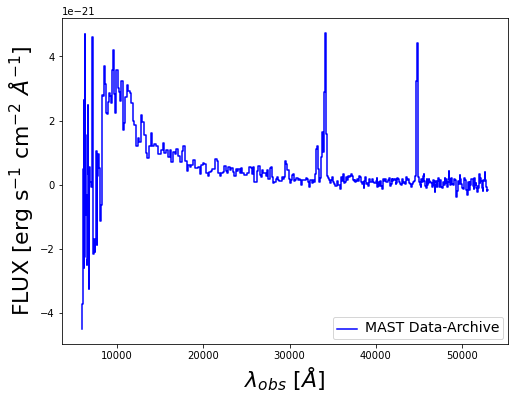

In [15]:
# Plot the spectrum
z2 = z_array[46]
mast_file_2 = mast_folder / MAST_files[46]


plot__mast_spectrum(mast_file_2, z = z2)

In [17]:
z = z2

with fits.open(mast_file_2) as f:
    
    specdata = f[1].data


    lamb_obs = specdata['WAVELENGTH'] * 1e-6/1e-10 
    lamb = specdata['WAVELENGTH'] * 1e-6/1e-10 / (1.+float(z)) * u.AA
    flux= specdata['FLUX']*2.99792458E-05/ lamb_obs**2 * u.Unit('erg cm-2 s-1 AA-1')
    spec= Spectrum1D(spectral_axis=lamb, flux=flux)
    cont_norm_spec = spec / fit_generic_continuum(spec)(spec.spectral_axis)

    EW_Ha=equivalent_width(cont_norm_spec, continuum=1, regions=SpectralRegion(6550 * u.AA, 6580 * u.AA))

    print(EW_Ha)

2799.6579351222144 Angstrom


Function that receives filename and redshift and returns EW for Halpha and [OIII]

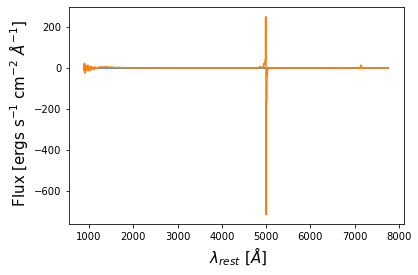

EW Halpha 82.8939650267107 Angstrom 
 EW Hbeta -159.97702105162477 Angstrom 
 EW [OIII] 6590.39713576625 Angstrom


In [ ]:
def compute_EW(file, z):
    with fits.open(file) as file:
        
        #Extract data from the file
        specdata=file[1].data
        
        #Compute rest wavelength
        lambda_obs = specdata['WAVELENGTH'] * 1e-6 / 1e-10 #convert from um to AA. 
        lambda_rest = lambda_obs / (1.+float(z)) 
        lambda_rest_Angstrom = lambda_rest * u.AA #u.AA just includes the units
        
        #Extract and convert flux to working units
        flux = specdata['FLUX'] * 2.99792458E-05 /lambda_obs**2 
        flux_Units = flux * u.Unit('erg cm-2 s-1 AA-1')
        
        #Define the spectrum over which the EW will be calculated, use class Spectrum1D from specutils
        spectrum = Spectrum1D(spectral_axis=lambda_rest_Angstrom, flux=flux_Units)
        
        #Plot the spectrum
        plt.step(spectrum.spectral_axis, spectrum.flux)
        #plt.show()
        
        with warnings.catch_warnings(): #ignore warnings
            warnings.simplefilter('ignore')
            
            # Normalize the spectrum by its continuum
            spec_continuum_fitted = fit_generic_continuum(spectrum)(spectrum.spectral_axis)
            normalized_continuum_spec = spectrum / spec_continuum_fitted
            
        #Plot the normalized continuum spectrum: the old spectrum normalized by the fitted continuum
        plt.step(normalized_continuum_spec.wavelength, normalized_continuum_spec.flux)
        plt.ylabel(r' Flux [ergs s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]', fontsize=15)
        plt.xlabel(r' $\lambda_{rest}$ [$\AA$]', fontsize=15)
        #plt.title(folders[i]+'_z='+str(z_Spec_2[j]),fontsize=6)
        plt.tick_params(axis='x',labelsize=10)
        plt.tick_params(axis='y',labelsize=10)
        #plt.savefig('v3/Plots_Clear-Prism_part_11_01/'+folders[i]+'.pdf')				
        plt.show()
        plt.close()	
        
        
        #plt.xlim(6450 , 6650)
        
        #Define Spectral Regions for the emission lines
        region_Ha = SpectralRegion(6550 * u.AA, 6580 * u.AA) #This is in rest frame since lambda=lambda_rest
        region_Hb = SpectralRegion(4815 * u.AA, 4917 * u.AA)
        region_OIII = SpectralRegion(4990 * u.AA, 5024 * u.AA)
        
        
        # Compute EW for Ha, Hb and [OIII]
        EW_Ha=equivalent_width(normalized_continuum_spec, regions=region_Ha)
        EW_Hb=equivalent_width(normalized_continuum_spec, regions=region_Hb)
        EW_OIII=equivalent_width(normalized_continuum_spec, continuum=1, regions=region_OIII) 
        print("EW Halpha", EW_Ha, "\n",
              "EW Hbeta", EW_Hb, "\n", 
              "EW [OIII]", EW_OIII)
        
        
        
        
compute_EW('./Spectra1D/JADES/hlsp_jades_jwst_nirspec_goods-s-deephst-10005113_clear-prism_v1.0_x1d.fits', 5.82)

Now let's build a function that receives the two files and compute the EW for the JADES and for the MAST files

In [ ]:
def compare_EW(mast_file, jades_file, z):
   
    
    with fits.open(mast_file) as m_f:        
        #Extract data from the file
        specdata=m_f[1].data
        
        #Compute rest wavelength
        lambda_obs = specdata['WAVELENGTH'] * 1e-6 / 1e-10 #convert from um to AA. 
        lambda_rest = lambda_obs / (1.+float(z)) 
        lambda_rest_Angstrom = lambda_rest * u.AA #u.AA just includes the units
        
        #Extract and convert flux to working units
        flux = specdata['FLUX'] * 2.99792458E-05 /lambda_obs**2 
        flux_Units = flux * u.Unit('erg cm-2 s-1 AA-1')
        
        #Define the spectrum over which the EW will be calculated, use class Spectrum1D from specutils
        mast_spectrum = Spectrum1D(spectral_axis=lambda_rest_Angstrom, flux=flux_Units)
        
        with warnings.catch_warnings(): #ignore warnings
            warnings.simplefilter('ignore')
            
            # Normalize the spectrum by its continuum
            spec_continuum_fitted = fit_generic_continuum(mast_spectrum)(mast_spectrum.spectral_axis)
            mast_normalized_continuum_spec = mast_spectrum / spec_continuum_fitted
            
        #Define Spectral Regions for the emission lines
        region_Ha = SpectralRegion(6550 * u.AA, 6580 * u.AA) #This is in rest frame since lambda=lambda_rest
        region_Hb = SpectralRegion(4815 * u.AA, 4917 * u.AA)
        region_OIII = SpectralRegion(4990 * u.AA, 5024 * u.AA)
        
        
        # Compute EW for Ha, Hb and [OIII]
        mast_EW_Ha=equivalent_width(mast_normalized_continuum_spec, regions=region_Ha)
        mast_EW_Hb=equivalent_width(mast_normalized_continuum_spec, regions=region_Hb)
        mast_EW_OIII=equivalent_width(mast_normalized_continuum_spec, continuum=1, regions=region_OIII) 
        
            
    with fits.open(jades_file) as j_f:
        #Extract data from the file
        specdata=j_f[1].data
        
        #Compute rest wavelength
        lambda_obs = specdata['WAVELENGTH'] * 1e-6 / 1e-10 #convert from um to AA. 
        lambda_rest = lambda_obs / (1.+float(z)) 
        lambda_rest_Angstrom = lambda_rest * u.AA #u.AA just includes the units
        
        #Extract and convert flux to working units
        flux = specdata['FLUX']
        flux_Units = flux * u.Unit('erg cm-2 s-1 AA-1')
        
        #Define the spectrum over which the EW will be calculated, use class Spectrum1D from specutils
        jades_spectrum = Spectrum1D(spectral_axis=lambda_rest_Angstrom, flux=flux_Units)
        
        with warnings.catch_warnings(): #ignore warnings
            warnings.simplefilter('ignore')
            
            # Normalize the spectrum by its continuum
            spec_continuum_fitted = fit_generic_continuum(jades_spectrum, exclude_regions=[SpectralRegion(lambda_rest_Angstrom[len(lambda_rest_Angstrom)-1] - (200*u.AA), lambda_rest_Angstrom[len(lambda_rest_Angstrom)-1]), SpectralRegion( lambda_rest_Angstrom[0], lambda_rest_Angstrom[0] + (200*u.AA))])(jades_spectrum.spectral_axis)
            jades_normalized_continuum_spec = jades_spectrum / spec_continuum_fitted
   
        #Define Spectral Regions for the emission lines
        region_Ha = SpectralRegion(6550 * u.AA, 6580 * u.AA) #This is in rest frame since lambda=lambda_rest
        region_Hb = SpectralRegion(4815 * u.AA, 4917 * u.AA)
        region_OIII = SpectralRegion(4990 * u.AA, 5024 * u.AA)
        
        
        # Compute EW for Ha, Hb and [OIII]
        jades_EW_Ha=equivalent_width(jades_normalized_continuum_spec, regions=region_Ha)
        jades_EW_Hb=equivalent_width(jades_normalized_continuum_spec, regions=region_Hb)
        jades_EW_OIII=equivalent_width(jades_normalized_continuum_spec, continuum=1, regions=region_OIII) 
        
    
    
    print("EW from mast file:\n", 
          "EW(Ha) =", mast_EW_Ha.value, "\n"
          "EW(Hb) =", mast_EW_Hb.value, "\n"
          "EW([OIII]) =", mast_EW_OIII.value, "\n")
    
    print('\n')
    
    print("EW from jades file:\n", 
          "EW(Ha) =", jades_EW_Ha.value, "\n"
          "EW(Hb) =", jades_EW_Hb.value, "\n"
          "EW([OIII]) =", jades_EW_OIII.value, "\n")
        

z = 5.82        
jadesFile = './Spectra1D/JADES/hlsp_jades_jwst_nirspec_goods-s-deephst-10005113_clear-prism_v1.0_x1d.fits'
mastFile = './Spectra1D/MAST/jw01210-o001_s000005113_nirspec_clear-prism_x1d.fits'

compare_EW(mastFile, jadesFile, z)

EW from mast file:
 EW(Ha) = 2800.0019400120837 
EW(Hb) = -67.36173567966544 
EW([OIII]) = -421.40116911368665 



EW from jades file:
 EW(Ha) = -814.2486605870791 
EW(Hb) = -140.50226067347006 
EW([OIII]) = -486.0266401661031 



They are terribly different. Let's make a function that compares the spectrum: normal, normalized, and sectioned

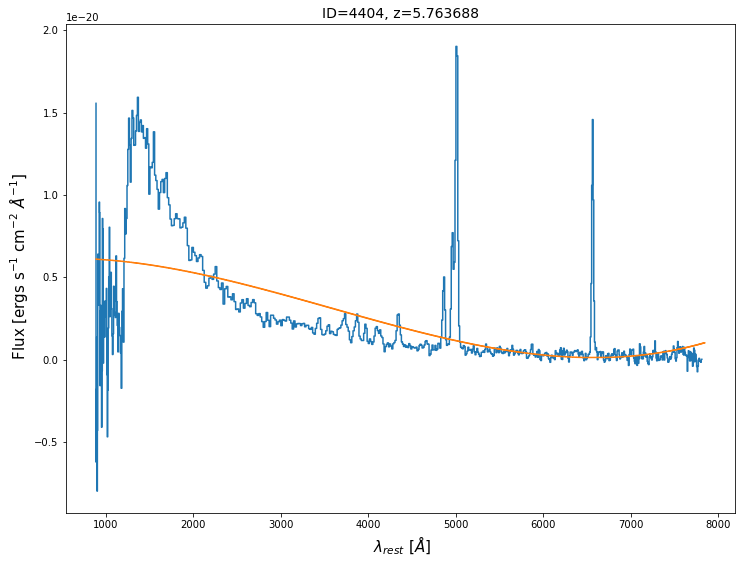

In [ ]:
def compare_spectrum(mast_file, jades_file, z, ID, whichSpectrum):
    
    with fits.open(mast_file) as m_f:        
        #Extract data from the file
        specdata=m_f[1].data
        
        #Compute rest wavelength
        lambda_obs = specdata['WAVELENGTH'] * 1e-6 / 1e-10 #convert from um to AA. 
        lambda_rest = lambda_obs / (1.+float(z)) 
        lambda_rest_Angstrom = lambda_rest * u.AA #u.AA just includes the units
        
        #Extract and convert flux to working units
        flux = specdata['FLUX'] * 2.99792458E-05 /lambda_obs**2 
        flux_Units = flux * u.Unit('erg cm-2 s-1 AA-1')
        
        
        #Define the spectrum over which the EW will be calculated, use class Spectrum1D from specutils
        mast_spectrum = Spectrum1D(spectral_axis=lambda_rest_Angstrom, flux=flux_Units)
        
        with warnings.catch_warnings(): #ignore warnings
            warnings.simplefilter('ignore')
            
            # Normalize the spectrum by its continuum
            spec_continuum_fitted = fit_generic_continuum(mast_spectrum)(mast_spectrum.spectral_axis)
            mast_normalized_continuum_spec = mast_spectrum / spec_continuum_fitted
        
        
            
    with fits.open(jades_file) as j_f:
        #Extract data from the file
        specdata=j_f[1].data
        
        #Compute rest wavelength
        lambda_obs = specdata['WAVELENGTH'] * 1e-6 / 1e-10 #convert from um to AA. 
        lambda_rest = lambda_obs / (1.+float(z)) 
        lambda_rest_Angstrom = lambda_rest * u.AA #u.AA just includes the units
        
        #Extract and convert flux to working units
        flux = specdata['FLUX']
        flux_Units = flux * u.Unit('erg cm-2 s-1 AA-1')
        
        #Define the spectrum over which the EW will be calculated, use class Spectrum1D from specutils
        jades_spectrum = Spectrum1D(spectral_axis=lambda_rest_Angstrom, flux=flux_Units)
        
        with warnings.catch_warnings(): #ignore warnings
            warnings.simplefilter('ignore')
            
            # Normalize the spectrum by its continuum
            jades_spec_continuum_fitted = fit_generic_continuum(jades_spectrum)(jades_spectrum.spectral_axis)
            jades_normalized_continuum_spec = jades_spectrum / jades_spec_continuum_fitted
    
    
        
    #Plot the spectrum
        #Original
    if whichSpectrum == "Ori": 
        plotSpectrum_1 = mast_spectrum
        plotSpectrum_2 = jades_spectrum
    
        #Normalized Continuum
    elif whichSpectrum == "NC":
        plotSpectrum_1 = mast_normalized_continuum_spec
        plotSpectrum_2 = jades_normalized_continuum_spec
    
        #H alpha
    elif whichSpectrum == "Ha":
        plotSpectrum_1 = mast_normalized_continuum_spec
        plotSpectrum_2 = jades_normalized_continuum_spec
        plt.xlim(6450 , 6650)
    
        #Hbeta
    elif whichSpectrum == "Hb":
        plotSpectrum_1 = mast_normalized_continuum_spec
        plotSpectrum_2 = jades_normalized_continuum_spec
        plt.xlim(4840 , 4880)
    
    
    
    plt.rcParams["figure.figsize"] = (12, 9)
    #plt.step(plotSpectrum_1.spectral_axis, plotSpectrum_1.flux)
    plt.step(plotSpectrum_2.spectral_axis, plotSpectrum_2.flux)
    plt.step(lambda_rest_Angstrom, jades_spec_continuum_fitted)
    
    #plt.step(normalized_continuum_spec.wavelength, normalized_continuum_spec.flux)
    plt.ylabel(r' Flux [ergs s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]', fontsize=15)
    plt.xlabel(r' $\lambda_{rest}$ [$\AA$]', fontsize=15)
    plt.title(f'ID={ID}, z={z}',fontsize=14)
    plt.tick_params(axis='x',labelsize=10)
    plt.tick_params(axis='y',labelsize=10)		
    plt.show()
    plt.close()	
    
        
        
        
indx = 20
z = z_array[indx]
ID = ID_array[indx]
mastFile = mast_folder / MAST_files[indx]
jadesFile = jades_folder / JADES_files[indx]


compare_spectrum(mastFile, jadesFile, z, ID, whichSpectrum='Ori')